In [3]:
import pandas as pd
import numpy as np
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
plotly.offline.init_notebook_mode(connected=True)

Using TensorFlow backend.
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packag

In [4]:
# Load BitCoin training data
bitcoin_data = pd.read_csv('BitCoin.csv')

In [5]:
print(bitcoin_data.shape)
bitcoin_data.head()

(10275, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [6]:

bitcoin_data['date'] = pd.to_datetime(bitcoin_data['Timestamp'],unit='s').dt.date
grouped_data = bitcoin_data.groupby('date')
real_price = grouped_data['Weighted_Price'].mean()

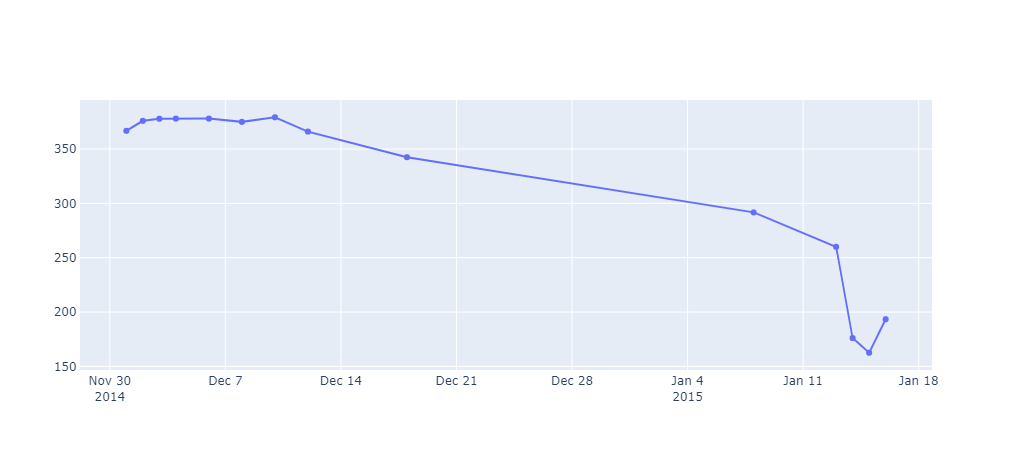

In [7]:
data = [go.Scatter(x=real_price.index, y=real_price.values)]

plotly.offline.iplot(data)

In [8]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [9]:
n_steps = 5

# split into samples
X, y = split_sequence(real_price.values, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# split into train - test set
X_train = X[0:-365]
y_train = y[0:-365]
X_test = X[-365:]
y_test = y[-365:]

# store the test dates
test_dates = real_price.index[-365:]

In [10]:
def build_bidirectional_model(X, y):
    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=200, verbose=1)
    return model

In [11]:
bidirectional_model = build_bidirectional_model(X, y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
9/9 [==============================] - 2s 182ms/step - loss: 140515.4688
Epoch 2/200
9/9 [==============================] - 0s 1ms/step - loss: 131840.6094
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 120552.1953
Epoch 4/200
9/9 [==============================] - 0s 2ms/step - loss: 108997.0000
Epoch 5/200
9/9 [==============================] - 0s 1ms/step - loss: 98856.4531
Epoch 6/200
9/9 [==============================] - 0s 1ms/step - loss: 89132.1562
Epoch 7/200
9/9 [==============================] - 0s 6ms/step - loss: 82073.6641
Epoch 8/200
9/9 [==============================] - 0s 1ms/step - loss: 77288.8828
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 72758.1328
Epoch 10/200
9/9 [==============================] - 0s 7ms/step - loss: 67489.6797
Epoch 11/200
9/9 [==============================] - 0

In [12]:
yhat = bidirectional_model.predict(X_test, verbose=0)